# About this Notebook:

* In this notebook i remove suspicious data for cleaning the dataset 
* i generate overlay mask on a slide and makes tiles, i save pictures in png
* i use fastai2 to trained a pretrained model resnet50
* i use all the radboud images for training the model

thank you all for sharing your work!!

# References
* Thanks to [PANDA: EDA, Visualizations & Suspicious Data](https://www.kaggle.com/iamleonie/panda-eda-visualizations-suspicious-data)
* Thanks to [Getting started with the PANDA dataset](http://www.kaggle.com/wouterbulten/getting-started-with-the-panda-dataset)
* Thanks to [PANDA 16x128x128 tiles](https://www.kaggle.com/iafoss/panda-16x128x128-tiles)

# If you found this helpful, please upvote!

In [1]:

# General packages
import sys
import gc
import os
import pandas as pd
import numpy as np
import time

from contextlib import contextmanager
#from pathlib import Path
from collections import defaultdict, Counter

import skimage.io
import cv2
import openslide
import PIL
from PIL import Image
import zipfile
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2

import warnings 
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Loading Dataset

In [2]:
# Location of the training images
path = '../input/prostate-cancer-grade-assessment'

# Location of training labels
df_train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')
sample = pd.read_csv(f'{path}/sample_submission.csv')

#load suspicious cases ( no mask on images)
suspicious = pd.read_csv(f'../input/suspiciousdata/suspicious_test_cases_V2.csv')

# image and mask directories
data_dir = f'{path}/train_images'
mask_dir = f'{path}/train_label_masks'

display(df_train.head())          
print("Shape of training data :", df_train.shape)
print("unique data provider :", len(df_train.data_provider.unique()))
print("unique isup_grade(target) :", df_train.isup_grade.unique())
print("unique gleason_score :", (df_train.gleason_score.unique()))
print("Number of suspicious images :", len(suspicious['image_id']))
print("Kind of Suspicious Data:", suspicious['Suspicious_because'].unique())

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


Shape of training data : (10616, 4)
unique data provider : 2
unique isup_grade(target) : [0 4 1 3 5 2]
unique gleason_score : ['0+0' '4+4' '3+3' '4+3' 'negative' '4+5' '3+4' '5+4' '5+5' '5+3' '3+5']
Number of suspicious images : 204
Kind of Suspicious Data: ['No Mask' 'Background only' 'No cancerous tissue but ISUP Grade > 0'
 'pen marked' nan]


#  Modify the data set:


* Remove all suspicious image for the training set
* Create a test set without the images Background 
* Remove images with pen marked

In [3]:
#remove all suspicious data of training set
train= df_train.copy().set_index('image_id')

for j in train.index:
    for i in suspicious['image_id']:
        if i == j:
            train.drop([i], axis=0, inplace = True)
            
train

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0
...,...,...,...
ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
ffe06afd66a93258f8fabdef6044e181,radboud,0,negative


# check distribution of isup grade

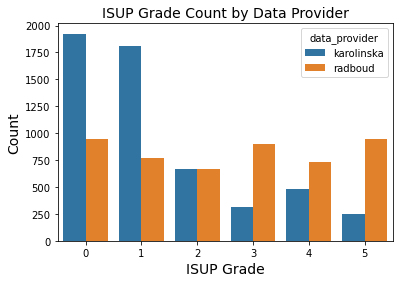

In [4]:
providers = train.data_provider.unique()

fig = plt.figure(figsize=(6,4))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
plt.title("ISUP Grade Count by Data Provider", fontsize=14)
plt.xlabel("ISUP Grade", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Preprocessing the data:

* overlay masks on the slide 

In [5]:
def overlay_mask_on_slide(slide, mask, center='radboud', alpha=0.8, max_size=(400, 400)):
    """Show a mask overlayed on a slide.
    
    """

    if center not in ['radboud', 'karolinska']:
        raise Exception("Unsupported palette, should be one of [radboud, karolinska].")

    # Load data from the highest level
    slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])

    # Mask data is present in the R channel
    mask_data = mask_data.split()[0]

    # Create alpha mask
    alpha_int = int(round(255*alpha))
    if center == 'radboud':
        alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
    elif center == 'karolinska':
        alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)
        
    alpha_content = PIL.Image.fromarray(alpha_content)
    preview_palette = np.zeros(shape=768, dtype=int)
    
    if center == 'radboud':
        # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
        preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
    elif center == 'karolinska':
        # Mapping: {0: background, 1: benign, 2: cancer}
        preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)
    
    mask_data.putpalette(data=preview_palette.tolist())
    mask_rgb = mask_data.convert(mode='RGB')

    overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
    overlayed_image = np.array(overlayed_image)

    return overlayed_image

> * create 16 tiles of size 128x128 of the overlay mask 

In [6]:
def tile(img, sz=128, N=16):
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                 constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    img = img[idxs]
    return img

# Generate tiles of overlayed mask in png : 


In [7]:
#use only if you want to select the provider images
train=train.loc[train.data_provider =='radboud']
train

,data_provider,isup_grade,gleason_score
image_id,,,
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3
006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3
007433133235efc27a39f11df6940829,radboud,0,negative
0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3
...,...,...,...
ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
ffe06afd66a93258f8fabdef6044e181,radboud,0,negative


In [8]:
#path to save the new pictures
save_dir = "../train_overlay/"
os.makedirs(save_dir, exist_ok=True)

#select the number of images to overlay and makes tiles
for imge in tqdm(train.index):
    
    # select the good provider corresponding at the picture
    prov = train.loc[imge,'data_provider']
    
    #open slide and mask images
    slide = openslide.OpenSlide(f'../input/prostate-cancer-grade-assessment/train_images/{imge}.tiff')
    mask = openslide.OpenSlide(f'../input/prostate-cancer-grade-assessment/train_label_masks/{imge}_mask.tiff')
    
    #overlay mask on a slide
    im1 = overlay_mask_on_slide(slide, mask, center= prov )
    
    #close slide and mask
    slide.close()
    mask.close()
    
    #ceate tiles 
    image= tile(im1, sz=128, N=16)
    
    #concatenate tiles on a picture
    image = cv2.hconcat([cv2.vconcat([image[0], image[1], image[2], image[3]]), 
                             cv2.vconcat([image[4], image[5], image[6], image[7]]), 
                             cv2.vconcat([image[8], image[9], image[10], image[11]]), 
                             cv2.vconcat([image[12], image[13], image[14], image[15]])])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #save the new picture
    matplotlib.image.imsave( save_dir+f'{imge}.png', image)

100%|██████████| 4961/4961 [13:42<00:00,  6.03it/s]


In [9]:
#check the number of new images:
onlyfiles = [f for f in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, f))]
print("Working with {0} images".format(len(onlyfiles)))

Working with 4961 images


In [10]:
#!ls ../train_overlay/

#zip the dataset in rar
#!tar -czf train_images.tar.gz ../train_overlay/*.png

In [11]:
#remove index on the dataframe and put the path on filename image_id
train.reset_index(drop=False, inplace=True)
train

,image_id,data_provider,isup_grade,gleason_score
0,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
1,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3
2,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3
3,007433133235efc27a39f11df6940829,radboud,0,negative
4,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3
...,...,...,...,...
4956,ffd2841373b39792ab0c84cccd066e31,radboud,0,negative
4957,ffdc59cd580a1468eac0e6a32dd1ff2d,radboud,5,4+5
4958,ffe06afd66a93258f8fabdef6044e181,radboud,0,negative
4959,ffe236a25d4cbed59438220799920749,radboud,2,3+4


# Utils


In [12]:
class CFG:
    debug=False
    height=256
    width=256
    lr=1e-4
    batch_size=16
    epochs=8
    seed=42
    target_size=6 #1
    target_col='isup_grade'
    n_fold=4

In [13]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')
    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('PANDA')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

# Dataset


In [14]:

class TrainDataset(Dataset):
    def __init__(self, df, labels, transform=None):
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../train_overlay/{file_name}.png'
        image = skimage.io.MultiImage(file_path)
        image = cv2.resize(image[-1], (CFG.height, CFG.width))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = self.labels[idx]
        
        return image, label
    
class TestDataset(Dataset):
    def __init__(self, df, dir_name, transform=None):
        self.df = df
        self.dir_name = dir_name
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['image_id'].values[idx]
        file_path = f'../input/prostate-cancer-grade-assessment/{self.dir_name}/{file_name}.tiff'
        image = skimage.io.MultiImage(file_path)
        image = cv2.resize(image[-1], (CFG.height, CFG.width))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image

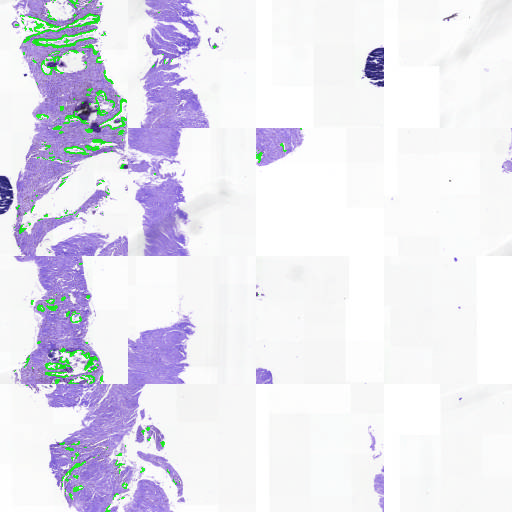

In [15]:
from IPython.display import display, Image

display(Image(filename ='../train_overlay/007433133235efc27a39f11df6940829.png'))

In [16]:

#del image; gc.collect()


# Transforms:

In [17]:
def get_transforms(*, data):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

#  train valid split

In [18]:
if CFG.debug:
    folds = train.sample(n=20, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds = train.copy()

In [19]:
train_labels = folds[CFG.target_col].values
kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
    folds.loc[val_index, 'fold'] = int(fold)
folds['fold'] = folds['fold'].astype(int)
folds.to_csv('folds.csv', index=None)
folds.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,3
1,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3,3
2,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,2
3,007433133235efc27a39f11df6940829,radboud,0,negative,1
4,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,3


# Model

In [20]:
from collections import OrderedDict
import math


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [21]:
pretrained_path = {'se_resnext50_32x4d': '../input/pytorch-se-resnext/se_resnext50_32x4d-a260b3a4.pth'}

class CustomSEResNeXt(nn.Module):

    def __init__(self, model_name='se_resnext50_32x4d'):
        assert model_name in ('se_resnext50_32x4d')
        super().__init__()
        
        self.model = se_resnext50_32x4d(pretrained=None)
        weights_path = pretrained_path[model_name]
        self.model.load_state_dict(torch.load(weights_path))
        self.model.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.model.last_linear = nn.Linear(self.model.last_linear.in_features, CFG.target_size)
        
    def forward(self, x):
        x = self.model(x)
        return x

# Train

In [22]:

from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

In [23]:
def train_fn(fold):
    
    print(f"### fold: {fold} ###")
        
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index
        
    train_dataset = TrainDataset(folds.loc[trn_idx].reset_index(drop=True), 
                                 folds.loc[trn_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(folds.loc[val_idx].reset_index(drop=True), 
                                 folds.loc[val_idx].reset_index(drop=True)[CFG.target_col], 
                                 transform=get_transforms(data='valid'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size)
    
    model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True, eps=1e-6)
    
    criterion = nn.CrossEntropyLoss()
    best_score = -100
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()

        model.train()
        avg_loss = 0.

        optimizer.zero_grad()
        tk0 = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (images, labels) in tk0:

            images = images.to(device)
            labels = labels.to(device)
            
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        avg_val_loss = 0.
        preds = []
        valid_labels = []
        tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

        for i, (images, labels) in tk1:
            
            images = images.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                y_preds = model(images)
            
            preds.append(y_preds.to('cpu').numpy().argmax(1))
            valid_labels.append(labels.to('cpu').numpy())

            loss = criterion(y_preds, labels)
            avg_val_loss += loss.item() / len(valid_loader)
        
        scheduler.step(avg_val_loss)
            
        preds = np.concatenate(preds)
        valid_labels = np.concatenate(valid_labels)
        
        LOGGER.debug(f'Counter preds: {Counter(preds)}')
        score = quadratic_weighted_kappa(valid_labels, preds)

        elapsed = time.time() - start_time
        
        LOGGER.debug(f'  Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch+1} - QWK: {score}')
        
        if score>best_score:
            best_score = score
            LOGGER.debug(f'  Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(), f'fold{fold}_se_resnext50.pth')

In [24]:
for fold in range(CFG.n_fold):
    train_fn(fold)

### fold: 0 ###


100%|██████████| 78/78 [00:22<00:00,  3.43it/s]
2020-05-23 07:29:51,072 DEBUG Counter preds: Counter({3: 274, 0: 266, 4: 261, 1: 204, 5: 179, 2: 57})
2020-05-23 07:29:51,076 DEBUG   Epoch 1 - avg_train_loss: 0.8132  avg_val_loss: 0.5891  time: 130s
2020-05-23 07:29:51,077 DEBUG   Epoch 1 - QWK: 0.9226736398531307
2020-05-23 07:29:51,078 DEBUG   Epoch 1 - Save Best Score: 0.9227 Model
100%|██████████| 78/78 [00:23<00:00,  3.33it/s]
2020-05-23 07:32:01,239 DEBUG Counter preds: Counter({3: 294, 0: 264, 4: 219, 1: 209, 5: 207, 2: 48})
2020-05-23 07:32:01,243 DEBUG   Epoch 2 - avg_train_loss: 0.4269  avg_val_loss: 0.6018  time: 130s
2020-05-23 07:32:01,244 DEBUG   Epoch 2 - QWK: 0.9253731830905274
2020-05-23 07:32:01,245 DEBUG   Epoch 2 - Save Best Score: 0.9254 Model
100%|██████████| 78/78 [00:23<00:00,  3.35it/s]
2020-05-23 07:34:10,813 DEBUG Counter preds: Counter({0: 266, 3: 237, 1: 207, 4: 200, 5: 182, 2: 149})
2020-05-23 07:34:10,817 DEBUG   Epoch 3 - avg_train_loss: 0.3076  avg_val_l

Epoch     6: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 78/78 [00:22<00:00,  3.42it/s]
2020-05-23 07:42:50,539 DEBUG Counter preds: Counter({0: 263, 5: 217, 3: 212, 1: 206, 4: 197, 2: 146})
2020-05-23 07:42:50,548 DEBUG   Epoch 7 - avg_train_loss: 0.0598  avg_val_loss: 0.6547  time: 130s
2020-05-23 07:42:50,549 DEBUG   Epoch 7 - QWK: 0.934166645753263
100%|██████████| 78/78 [00:23<00:00,  3.32it/s]
2020-05-23 07:45:00,616 DEBUG Counter preds: Counter({0: 260, 5: 225, 1: 208, 3: 195, 4: 190, 2: 163})
2020-05-23 07:45:00,620 DEBUG   Epoch 8 - avg_train_loss: 0.0297  avg_val_loss: 0.6946  time: 130s
2020-05-23 07:45:00,621 DEBUG   Epoch 8 - QWK: 0.9395110505673367
2020-05-23 07:45:00,622 DEBUG   Epoch 8 - Save Best Score: 0.9395 Model


### fold: 1 ###


100%|██████████| 78/78 [00:23<00:00,  3.25it/s]
2020-05-23 07:47:11,890 DEBUG Counter preds: Counter({4: 258, 0: 256, 1: 208, 5: 189, 3: 174, 2: 155})
2020-05-23 07:47:11,894 DEBUG   Epoch 1 - avg_train_loss: 0.8161  avg_val_loss: 0.5363  time: 131s
2020-05-23 07:47:11,895 DEBUG   Epoch 1 - QWK: 0.9456095671016937
2020-05-23 07:47:11,896 DEBUG   Epoch 1 - Save Best Score: 0.9456 Model
100%|██████████| 78/78 [00:22<00:00,  3.40it/s]
2020-05-23 07:49:21,937 DEBUG Counter preds: Counter({5: 252, 0: 248, 1: 210, 4: 201, 3: 200, 2: 129})
2020-05-23 07:49:21,941 DEBUG   Epoch 2 - avg_train_loss: 0.4325  avg_val_loss: 0.4865  time: 130s
2020-05-23 07:49:21,941 DEBUG   Epoch 2 - QWK: 0.9412297726308754
100%|██████████| 78/78 [00:23<00:00,  3.38it/s]
2020-05-23 07:51:32,017 DEBUG Counter preds: Counter({5: 305, 0: 251, 1: 207, 2: 182, 3: 163, 4: 132})
2020-05-23 07:51:32,021 DEBUG   Epoch 3 - avg_train_loss: 0.2977  avg_val_loss: 0.5914  time: 130s
2020-05-23 07:51:32,022 DEBUG   Epoch 3 - QWK:

Epoch     5: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 78/78 [00:24<00:00,  3.25it/s]
2020-05-23 07:58:04,452 DEBUG Counter preds: Counter({0: 249, 5: 244, 1: 202, 3: 199, 4: 194, 2: 152})
2020-05-23 07:58:04,456 DEBUG   Epoch 6 - avg_train_loss: 0.0830  avg_val_loss: 0.5340  time: 131s
2020-05-23 07:58:04,457 DEBUG   Epoch 6 - QWK: 0.9491207473475314
2020-05-23 07:58:04,458 DEBUG   Epoch 6 - Save Best Score: 0.9491 Model
100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
2020-05-23 08:00:15,551 DEBUG Counter preds: Counter({0: 246, 5: 232, 3: 222, 1: 204, 4: 195, 2: 141})
2020-05-23 08:00:15,555 DEBUG   Epoch 7 - avg_train_loss: 0.0440  avg_val_loss: 0.5949  time: 131s
2020-05-23 08:00:15,556 DEBUG   Epoch 7 - QWK: 0.9520071952346315
2020-05-23 08:00:15,558 DEBUG   Epoch 7 - Save Best Score: 0.9520 Model
100%|██████████| 78/78 [00:23<00:00,  3.32it/s]
2020-05-23 08:02:27,591 DEBUG Counter preds: Counter({0: 248, 3: 236, 5: 234, 1: 203, 4: 194, 2: 125})
2020-05-23 08:02:27,595 DEBUG   Epoch 8 - avg_train_loss: 0.0239  avg_val

Epoch     8: reducing learning rate of group 0 to 2.5000e-05.
### fold: 2 ###


100%|██████████| 78/78 [00:23<00:00,  3.31it/s]
2020-05-23 08:04:40,067 DEBUG Counter preds: Counter({3: 280, 4: 259, 0: 249, 1: 205, 5: 194, 2: 53})
2020-05-23 08:04:40,072 DEBUG   Epoch 1 - avg_train_loss: 0.8278  avg_val_loss: 0.5476  time: 132s
2020-05-23 08:04:40,073 DEBUG   Epoch 1 - QWK: 0.9423968521259861
2020-05-23 08:04:40,075 DEBUG   Epoch 1 - Save Best Score: 0.9424 Model
100%|██████████| 78/78 [00:23<00:00,  3.28it/s]
2020-05-23 08:06:52,420 DEBUG Counter preds: Counter({4: 257, 3: 248, 0: 245, 1: 210, 5: 209, 2: 71})
2020-05-23 08:06:52,425 DEBUG   Epoch 2 - avg_train_loss: 0.4582  avg_val_loss: 0.5002  time: 132s
2020-05-23 08:06:52,427 DEBUG   Epoch 2 - QWK: 0.9482612338160016
2020-05-23 08:06:52,428 DEBUG   Epoch 2 - Save Best Score: 0.9483 Model
100%|██████████| 78/78 [00:24<00:00,  3.20it/s]
2020-05-23 08:09:06,041 DEBUG Counter preds: Counter({3: 254, 0: 247, 4: 226, 5: 215, 1: 200, 2: 98})
2020-05-23 08:09:06,045 DEBUG   Epoch 3 - avg_train_loss: 0.3048  avg_val_lo

Epoch     5: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
2020-05-23 08:15:46,770 DEBUG Counter preds: Counter({0: 247, 5: 234, 3: 227, 1: 209, 4: 190, 2: 133})
2020-05-23 08:15:46,774 DEBUG   Epoch 6 - avg_train_loss: 0.0905  avg_val_loss: 0.4661  time: 134s
2020-05-23 08:15:46,775 DEBUG   Epoch 6 - QWK: 0.9599712001856787
2020-05-23 08:15:46,776 DEBUG   Epoch 6 - Save Best Score: 0.9600 Model
100%|██████████| 78/78 [00:23<00:00,  3.26it/s]
2020-05-23 08:17:59,811 DEBUG Counter preds: Counter({0: 246, 5: 236, 3: 226, 1: 212, 4: 180, 2: 140})
2020-05-23 08:17:59,815 DEBUG   Epoch 7 - avg_train_loss: 0.0420  avg_val_loss: 0.5089  time: 133s
2020-05-23 08:17:59,816 DEBUG   Epoch 7 - QWK: 0.9558749544965581
100%|██████████| 78/78 [00:24<00:00,  3.24it/s]
2020-05-23 08:20:12,201 DEBUG Counter preds: Counter({0: 248, 3: 237, 5: 227, 4: 210, 1: 207, 2: 111})
2020-05-23 08:20:12,205 DEBUG   Epoch 8 - avg_train_loss: 0.0304  avg_val_loss: 0.6239  time: 132s
2020-05-23 08:20:12,206 DEBUG   Epoch 8 - QWK:

### fold: 3 ###


100%|██████████| 78/78 [00:23<00:00,  3.28it/s]
2020-05-23 08:22:24,591 DEBUG Counter preds: Counter({0: 251, 4: 249, 1: 219, 5: 216, 3: 198, 2: 107})
2020-05-23 08:22:24,595 DEBUG   Epoch 1 - avg_train_loss: 0.8136  avg_val_loss: 0.5398  time: 132s
2020-05-23 08:22:24,597 DEBUG   Epoch 1 - QWK: 0.933945083708118
2020-05-23 08:22:24,598 DEBUG   Epoch 1 - Save Best Score: 0.9339 Model
100%|██████████| 78/78 [00:23<00:00,  3.36it/s]
2020-05-23 08:24:36,476 DEBUG Counter preds: Counter({4: 261, 0: 250, 1: 218, 5: 207, 3: 153, 2: 151})
2020-05-23 08:24:36,480 DEBUG   Epoch 2 - avg_train_loss: 0.4397  avg_val_loss: 0.6003  time: 132s
2020-05-23 08:24:36,481 DEBUG   Epoch 2 - QWK: 0.9340154966942507
2020-05-23 08:24:36,482 DEBUG   Epoch 2 - Save Best Score: 0.9340 Model
100%|██████████| 78/78 [00:22<00:00,  3.41it/s]
2020-05-23 08:26:46,455 DEBUG Counter preds: Counter({5: 264, 0: 243, 1: 215, 4: 194, 3: 167, 2: 157})
2020-05-23 08:26:46,459 DEBUG   Epoch 3 - avg_train_loss: 0.2916  avg_val_

Epoch     4: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 78/78 [00:23<00:00,  3.30it/s]
2020-05-23 08:31:06,607 DEBUG Counter preds: Counter({0: 246, 5: 230, 4: 214, 1: 214, 2: 169, 3: 167})
2020-05-23 08:31:06,611 DEBUG   Epoch 5 - avg_train_loss: 0.1038  avg_val_loss: 0.6025  time: 130s
2020-05-23 08:31:06,612 DEBUG   Epoch 5 - QWK: 0.9405522642132448
2020-05-23 08:31:06,613 DEBUG   Epoch 5 - Save Best Score: 0.9406 Model
100%|██████████| 78/78 [00:23<00:00,  3.35it/s]
2020-05-23 08:33:16,243 DEBUG Counter preds: Counter({0: 245, 5: 219, 3: 219, 1: 217, 4: 208, 2: 132})
2020-05-23 08:33:16,247 DEBUG   Epoch 6 - avg_train_loss: 0.0571  avg_val_loss: 0.6485  time: 129s
2020-05-23 08:33:16,248 DEBUG   Epoch 6 - QWK: 0.9422546707595137
2020-05-23 08:33:16,249 DEBUG   Epoch 6 - Save Best Score: 0.9423 Model
100%|██████████| 78/78 [00:23<00:00,  3.39it/s]
2020-05-23 08:35:26,312 DEBUG Counter preds: Counter({0: 248, 3: 219, 5: 216, 4: 213, 1: 207, 2: 137})
2020-05-23 08:35:26,316 DEBUG   Epoch 7 - avg_train_loss: 0.0359  avg_val

Epoch     7: reducing learning rate of group 0 to 2.5000e-05.


100%|██████████| 78/78 [00:23<00:00,  3.35it/s]
2020-05-23 08:37:37,146 DEBUG Counter preds: Counter({0: 244, 4: 222, 5: 216, 1: 215, 3: 187, 2: 156})
2020-05-23 08:37:37,151 DEBUG   Epoch 8 - avg_train_loss: 0.0240  avg_val_loss: 0.7212  time: 131s
2020-05-23 08:37:37,152 DEBUG   Epoch 8 - QWK: 0.9416188175076112


# inference

In [25]:
def inference(model, test_loader, device):
    
    model.to(device) 
    
    probs = []

    for i, images in enumerate(test_loader):
            
        images = images.to(device)
            
        with torch.no_grad():
            y_preds = model(images)
            
        probs.append(y_preds.to('cpu').numpy())

    probs = np.concatenate(probs)
    
    return probs

In [26]:
def submit(sample, dir_name='test_images'):
    if os.path.exists(f'../input/prostate-cancer-grade-assessment/{dir_name}'):
        print('run inference')
        test_dataset = TestDataset(sample, dir_name, transform=get_transforms(data='valid'))
        test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
        probs = []
        for fold in range(CFG.n_fold):
            model = CustomSEResNeXt(model_name='se_resnext50_32x4d')
            weights_path = f'fold{fold}_se_resnext50.pth'
            model.load_state_dict(torch.load(weights_path, map_location=device))
            _probs = inference(model, test_loader, device)
            probs.append(_probs)
        probs = np.mean(probs, axis=0)
        preds = probs.argmax(1)
        sample['isup_grade'] = preds
    return sample

In [27]:
# check using train_images
submission = submit(train.head(), dir_name='train_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()



run inference


,image_id,data_provider,isup_grade,gleason_score
0,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
1,0068d4c7529e34fd4c9da863ce01a161,radboud,3,4+3
2,006f6aa35a78965c92fffd1fbd53a058,radboud,1,4+3
3,007433133235efc27a39f11df6940829,radboud,0,negative
4,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,5,4+3


In [28]:
# test submission
submission = submit(sample, dir_name='test_images')
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)
submission.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0
